In [1]:
#Retrieving angles from CV results
import datetime
import csv

with open("occlusion_sanity.csv", newline='') as csvfile:

    csvreader = csv.reader(csvfile)

    computer_vision_results = []

    for row in csvreader:
        try:
            
            #getting the landmarks of shoulder, elbow, wrist (in string)
            shoulder_landmark = row[-24]
            elbow_landmark = row[-22]
            wrist_landmark = row[-20]

            #getting the visibility value of each landmark
            #vis_shoulder = get_visibility(shoulder_landmark)
            #vis_elbow = get_visibility(elbow_landmark)
            #vis_wrist = get_visibility(wrist_landmark)
           
            
            #only adding the angles from CV results that are inbetween the time stamps of the quaternion data
            #if datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S.%f') > datetime.datetime.strptime(timestamps[0], '%m/%d/%Y %H:%M:%S.%f') or datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S.%f') < datetime.datetime.strptime(timestamps[-1], '%m/%d/%Y %H:%M:%S.%f'):
                
                #if visbility value of shoulder, elbow and wrist are above threshold, then add the data points
                #if vis_shoulder > 0.1 and vis_elbow > 0.1 and vis_wrist > 0.1:
            computer_vision_results.append([row[-3]] + [row[0]]) #the third last column is angle, first column is timestamp
            
        except:
            pass

In [2]:
CV_angles = []
CV_time_stamps = []
for i in computer_vision_results:
    try:
        CV_angles.append(float(i[0]))
        CV_time_stamps.append(i[1])
    except:
        pass

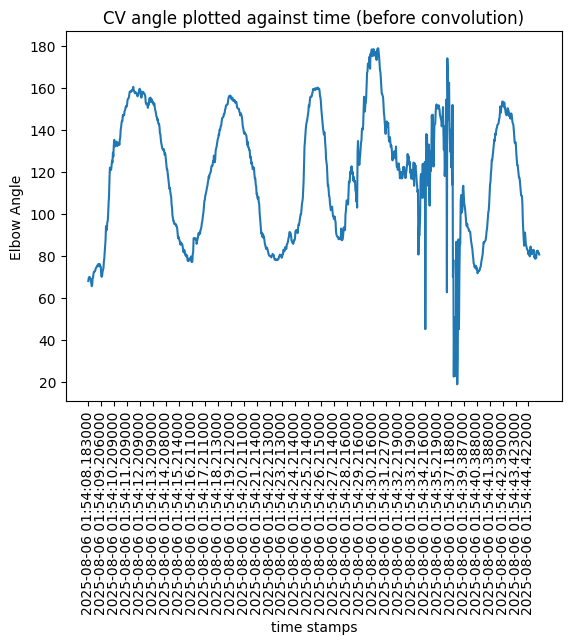

In [3]:
import matplotlib.pyplot as plt

plt.plot(CV_time_stamps, CV_angles)
plt.xlabel("time stamps")

x_index = [i for i in range(len(CV_time_stamps)) if i % 30 == 0]
x_labels = [CV_time_stamps[i] for i in x_index]
plt.xticks(x_index, x_labels, rotation=90)


plt.ylabel("Elbow Angle")
plt.title("CV angle plotted against time (before convolution)")
plt.show()

In [4]:
#smoothing using convolution 

def smooth_signal(angles, window_size):
    smoothed_signal = []
    half = window_size // 2
    for i in range(0, len(angles)):
        if i - half < 0:
            angles_to_avg = angles[0: i + half]
            angles_avg = sum(angles_to_avg) / len(angles_to_avg)
            smoothed_signal.append(angles_avg)
        else:
            angles_to_avg = angles[i - half: i + half + 1] #python slicing is not inclusive so added +1
            angles_avg = sum(angles_to_avg) / len(angles_to_avg)
            smoothed_signal.append(angles_avg)        
    return smoothed_signal

x = smooth_signal(CV_angles, 11)

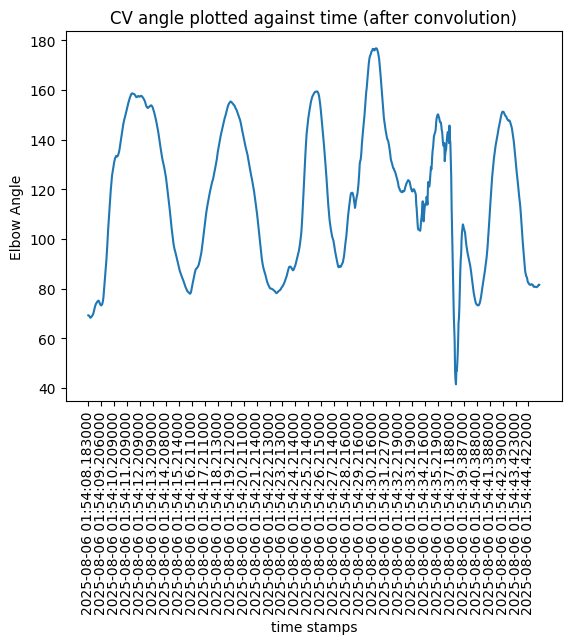

In [5]:
import matplotlib.pyplot as plt

plt.plot(CV_time_stamps, x)
plt.xlabel("time stamps")

x_index = [i for i in range(len(CV_time_stamps)) if i % 30 == 0]
x_labels = [CV_time_stamps[i] for i in x_index]
plt.xticks(x_index, x_labels, rotation=90)


plt.ylabel("Elbow Angle")
plt.title("CV angle plotted against time (after convolution)")
plt.show()

In [6]:
import numpy as np 

#make timestamps into relative time stamps

CV_time_stamps_datetime = []

for i in CV_time_stamps:
    date_time = datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S.%f")
    CV_time_stamps_datetime.append(date_time)
t0 = CV_time_stamps_datetime[0]
relative_time_CV = [] 
for i in CV_time_stamps_datetime:
    rel_time = i - t0
    relative_time_CV.append(rel_time.total_seconds())


#calculate velocity and angular velocity

angle_diff = np.diff(x) #subtract angle[i+1] from angle[i]
time_diff = np.diff(relative_time_CV) #subtract relative_time[i+1] from relative_time[i]

velocity = angle_diff / time_diff 

velocity_times = []
for i in range(0, len(relative_time_CV)):
    if i < len(relative_time_CV)-1:
        midpoint = (relative_time_CV[i] + relative_time_CV[i+1])/2
        velocity_times.append(midpoint)

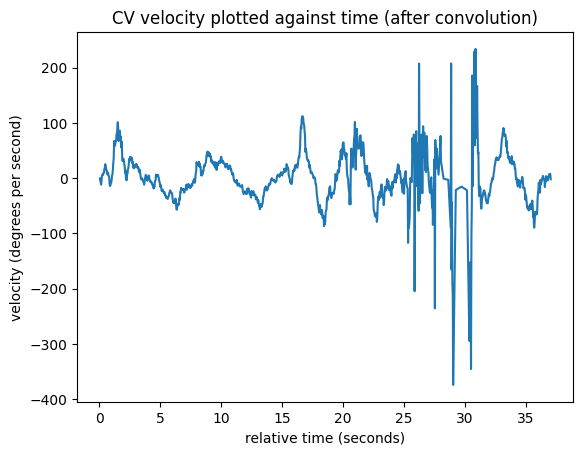

In [7]:
import matplotlib.pyplot as plt

plt.plot(velocity_times, velocity)
plt.xlabel("relative time (seconds)")

plt.ylabel("velocity (degrees per second)")
plt.title("CV velocity plotted against time (after convolution)")
plt.show()


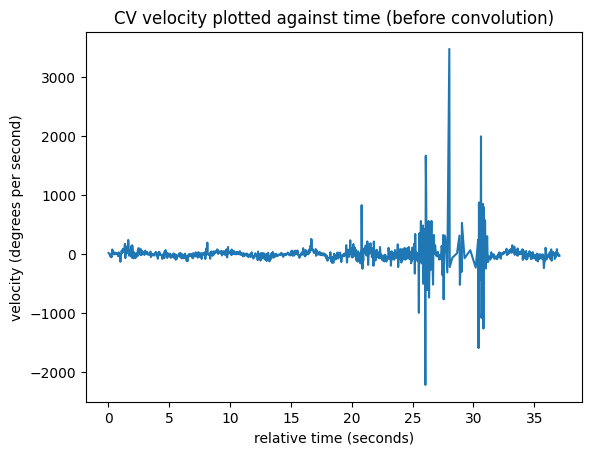

In [8]:
#checking velocity without smoothing before

angle_diff = np.diff(CV_angles)
time_diff = np.diff(relative_time_CV)

velocity = angle_diff / time_diff

#print(velocity)

velocity_times = []
for i in range(0, len(relative_time_CV)):
    if i < len(relative_time_CV)-1:
        midpoint = (relative_time_CV[i] + relative_time_CV[i+1])/2
        velocity_times.append(midpoint)

#print(velocity_times)



import matplotlib.pyplot as plt

plt.plot(velocity_times, velocity)
plt.xlabel("relative time (seconds)")

plt.ylabel("velocity (degrees per second)")
plt.title("CV velocity plotted against time (before convolution)")
plt.show()

In [9]:
#sanity check for IMU sensors
import csv 

#getting quaternino data from first IMU sensor

#getting quaternion data from second IMU sensor


with open("sanity_quaternion_2.csv", newline='') as csvfile:

    csvreader = csv.reader(csvfile, delimiter='\t')
    sensor2 = []
    for row in csvreader:
        sensor2.append(row)
        
sensor_2_clean_data = sensor2[3:]



with open("sanity_quaternion_3.csv", newline='') as csvfile:

    csvreader = csv.reader(csvfile, delimiter='\t')
    sensor3 = []
    for row in csvreader:
        sensor3.append(row)
        
sensor_3_clean_data = sensor3[3:]

In [10]:
def multiply_quaternions(q1,q2):
    w1,x1,y1,z1 = q1
    w2,x2,y2,z2 = q2

    return[
        w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
        w1 * w2 + x1 * w2 + y1 * z2 - z1 * y2,
        w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
        w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    ]

def quaternion_to_angle(sensor_array_1, sensor_array_2):

    angles_from_quaternions = []
    counter = 0

    for i in sensor_array_1:
        w1,x1,y1,z1 = float(i[1]), float(i[2]),float(i[3]), float(i[4])
        q1_conjugate = [w1, -x1, -y1, -z1]
        angle_calculated = False
        
        while angle_calculated == False and counter <len(sensor_array_2):
            k = sensor_array_2[counter]
            w2,x2,y2,z2 = float(k[1]), float(k[2]), float(k[3]), float(k[4])
            q2 = [w2, x2,y2,z2]

            #q_relative is the conjugate * q2
            q_relative = multiply_quaternions(q1_conjugate, q2) 
            
            #calculating angle from q_relative
            theta = 2 * np.arccos(q_relative[0])
            theta_deg = theta * (180/np.pi)

            angles_from_quaternions.append([theta_deg] + [k[0]])
            counter+=1
            angle_calculated = True
    
    
    return angles_from_quaternions

In [11]:
angles_with_timestamps = quaternion_to_angle(sensor_2_clean_data, sensor_3_clean_data)

angles = []
timestamps = []

for i in angles_with_timestamps:
    angles.append(i[0])
    timestamps.append(i[1])

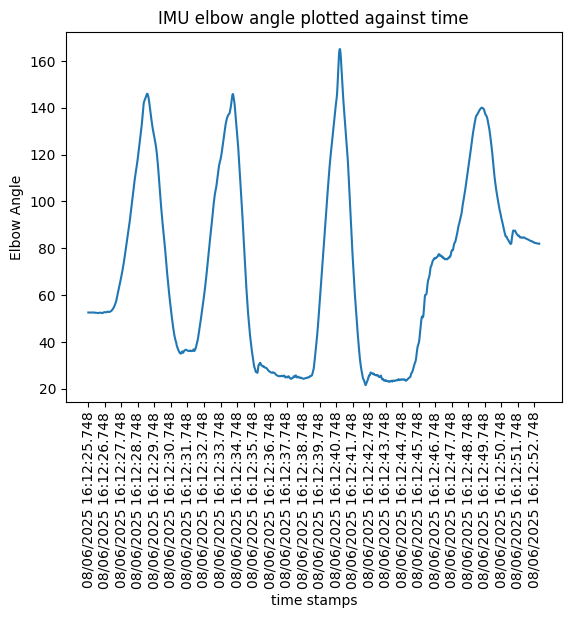

In [12]:
import matplotlib.pyplot as plt

plt.plot(timestamps, angles)
plt.xlabel("time stamps")

#too many xlables, reduced to 1 in 10
x_index = [i for i in range(len(timestamps)) if i % 100 == 0]
x_labels = [timestamps[i] for i in x_index]
plt.xticks(x_index, x_labels, rotation=90)

plt.ylabel("Elbow Angle")
plt.title("IMU elbow angle plotted against time")
plt.show()

In [13]:
IMU_time_stamps_datetime = []

for i in timestamps:
    date_time = datetime.datetime.strptime(i, "%m/%d/%Y %H:%M:%S.%f")
    IMU_time_stamps_datetime.append(date_time)

t0 = IMU_time_stamps_datetime[0]
relative_time_IMU = []
for i in IMU_time_stamps_datetime:
    rel_time = i - t0
    relative_time_IMU.append(rel_time.total_seconds())

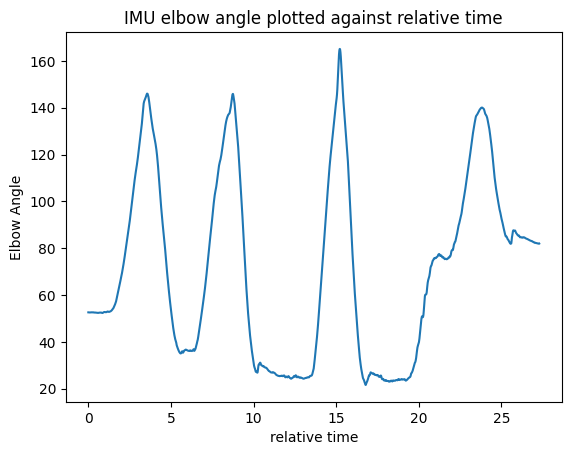

In [14]:
import matplotlib.pyplot as plt

plt.plot(relative_time_IMU, angles)
plt.xlabel("relative time")


plt.ylabel("Elbow Angle")
plt.title("IMU elbow angle plotted against relative time")
plt.show()

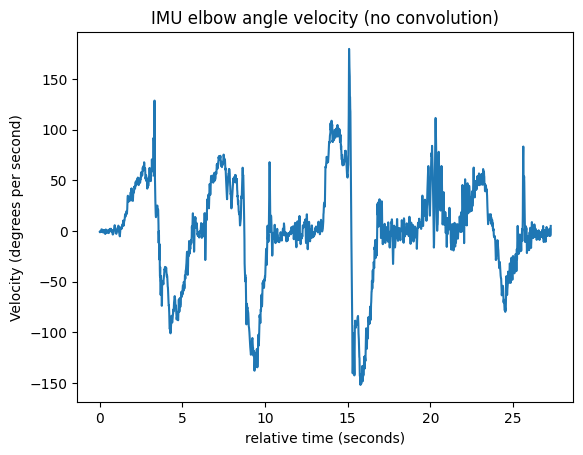

In [15]:
angle_diff = np.diff(angles)
time_diff = np.diff(relative_time_IMU) 

velocity = angle_diff / time_diff 

velocity_times = []
for i in range(0, len(relative_time_IMU)):
    if i < len(relative_time_IMU)-1:
        midpoint = (relative_time_IMU[i] + relative_time_IMU[i+1])/2
        velocity_times.append(midpoint)

plt.plot(velocity_times, velocity)
plt.xlabel("relative time (seconds)")

plt.ylabel("Velocity (degrees per second)")
plt.title("IMU elbow angle velocity (no convolution)")
plt.show()